In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from statsmodels.regression.linear_model import OLS

### Vasicek Model Yield Curve

In finance, the Vasicek model is a mathematical model describing the evolution of interest rates. It is a type of one-factor short-rate model as it describes interest rate movements as driven by only one source of market risk. The model can be used in the valuation of interest rate derivatives, and has also been adapted for credit markets.

### Ornstein - Uhlenbeck Process 

A mean-reverting Ornstein-Uhlenbeck (Vasicek) process $Xt$ with parameters $\mu, \theta, \sigma$ is characterized
by the stochastic differential equation
\begin{equation}
dX_t = \theta (\mu - X_t) dt + \sigma dW(t)
\end{equation}

Where $W_t$ is a Standard Brownian Motion and $X_0 = x_0$. It can be shown that $X_t$ is normally distributed with :

\begin{equation}
E[X_t] = \mu + (x_0 - \mu) e^{-\theta t}
\end{equation}

\begin{equation}
Var[X_t] = \frac{\sigma^2}{2\theta}(1-e^{-2\theta t})
\end{equation}

Below, we will try to model and calibrate swap rates at different maturities given by the Fed using a Vasicek model and compare different methods of parameters estimation.

### Swap rates Dataset

All the data has been retrieved from the following website: https://fred.stlouisfed.org/categories/32299 
Here, we took the daily swap rates of the Fed between 2000-07-03 to 2016-10-28 (2016-10-31) where a mean-reverting model will be fitted in order to find the best parameters of the Vasicek model using MLE, OLS and machine learning. 

### Data exploration

In [2]:
swap_rates = pd.read_excel('US_swap_rates.xlsx').set_index('observation_date')
swap_rates = swap_rates.dropna()
swap_rates

,DSWP1,DSWP5,DSWP10
observation_date,,,
2011-10-28,0.55,1.41,2.46
2011-10-31,0.52,1.32,2.36
2011-11-01,0.55,1.24,2.18
2011-11-02,0.54,1.25,2.22
2011-11-03,0.55,1.23,2.21
...,...,...,...
2016-10-24,0.99,1.30,1.61
2016-10-25,1.00,1.29,1.59
2016-10-26,1.01,1.33,1.64


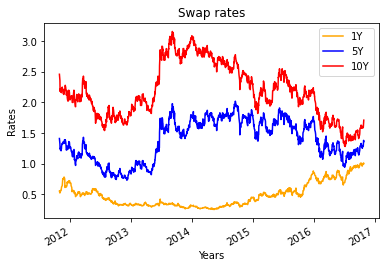

In [3]:
#plot the swap rates at 1Y, 5Y and 10Y

swap_rates.DSWP1.plot(label='1Y',color='orange')
swap_rates.DSWP5.plot(label='5Y',color='blue')
swap_rates.DSWP10.plot(label='10Y',color='red')

plt.title('Swap rates')
plt.xlabel('Years')
plt.ylabel('Rates')
plt.legend()

Now let's plot the daily changes of the swap rates 

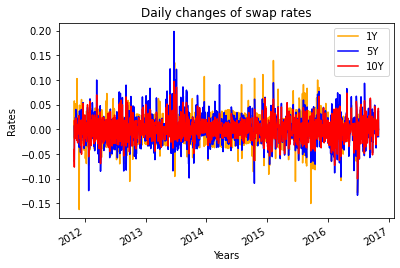

In [4]:
#Now the same but for volatility

swap_rates.DSWP1.pct_change().dropna().plot(label='1Y',color='orange')
swap_rates.DSWP5.pct_change().dropna().plot(label='5Y',color='blue')
swap_rates.DSWP10.pct_change().dropna().plot(label='10Y',color='red')

plt.title('Daily changes of swap rates')
plt.xlabel('Years')
plt.ylabel('Rates')
plt.legend()

### Path simulation of the process

the process verifies : 
\begin{equation}
dX_t = \theta (\mu - X_t) dt + \sigma dW(t)
\end{equation}
Using Ito Calculus, we know that a solution $X_t$ has the following form: 

\begin{equation}
X_t = X_0 e^{-\theta t} + \theta(1 - e^{-\theta t}) + \sigma \int_{0}^{t} e^{-\theta (t-s)}dW_s
\end{equation}

Using Euler-Maruyama scheme for SDE, we can find a solution numerically using the following formula: 

$\Delta x_{t+1} = \theta(\mu - x_t)\Delta t + \sigma \sqrt{\Delta t}\epsilon_t$

In [47]:
def simulate_vasicek_euler(r0, theta, mu, sigma, T, dt):
    n_steps = int(T / dt)
    dW = np.random.normal(0, np.sqrt(dt), n_steps)
    short_rate_path = np.zeros(n_steps + 1)
    short_rate_path[0] = r0

    for i in range(1, n_steps + 1):
        short_rate_path[i] = (short_rate_path[i - 1] + theta * (mu - short_rate_path[i - 1]) * dt
                              + sigma * np.sqrt(dt) * dW[i - 1])

    return short_rate_path

In [48]:
def simulate_vasicek_euler_average(r0, theta, mu, sigma, T, dt, n_paths):
    n_steps = int(T / dt)
    dW_matrix = np.random.normal(0, np.sqrt(dt), (n_paths, n_steps))
    short_rate_matrix = np.zeros((n_paths, n_steps + 1))
    short_rate_matrix[:, 0] = r0

    for i in range(1, n_steps + 1):

        short_rate_matrix[:, i] = (short_rate_matrix[:, i - 1] + theta * (mu - short_rate_matrix[:, i - 1]) * dt
                                                               + sigma * np.sqrt(dt) * dW_matrix[:, i - 1])

  
    return np.mean(short_rate_matrix, axis=0)

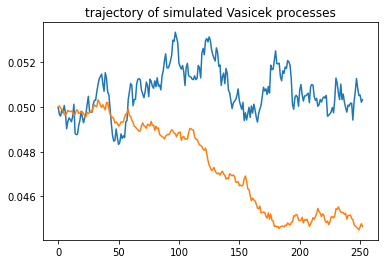

In [49]:
rates1 = simulate_vasicek_euler(0.05,0.1,0.05,0.1,1,1/252)
rates_averaged = simulate_vasicek_euler_average(0.05,0.1,0.02,0.1,1,1/252,10)
plt.plot(rates1)
plt.plot(rates_averaged)
plt.title('trajectory of simulated Vasicek processes')
plt.show()

### MLE Estimation

Now, we know that our stochastic process is normally distributed with $E[X_t]$ and $Var[X_t]$ and that: 

source : http://www.investmentscience.com/Content/howtoArticles/MLE_for_OR_mean_reverting.pdf

KU Leuven : https://lirias.kuleuven.be/retrieve/7024

$X_t \sim N(\mu,\sigma)$


$E[X_{t+ \delta t}] = X_te^{-k\delta t} + \theta (1-e^{-k\delta t}) $

$Var[X_{t+ \delta t}] = \frac{\sigma^2}{2k}(1 - e^{-k\delta t})$

Then we know that the likelihood estimator verifies : 

$\hat{\theta}_{MLE} = arg max_\theta L(\theta|x) $

where $L(\theta) = \Pi^n_{i=1}f(X_i|\theta) $
 
as the increments of the Ornstein Uhlenbeck process are normally distributed we know that the density function is : 
 
$f_\theta(x_{t+\delta t}|x,k,\theta,\sigma) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2}$ 

with $\mu = E[X_{t+ \delta t}]$ and $\sigma = Var[X_{t+ \delta t}]$

In [8]:
from scipy.optimize import minimize
import scipy.stats
#let's implement the functions above

def mean(x,dt,k,theta):
    return x* np.exp(-k*dt) + theta*(1-np.exp(-k*dt))

def var(dt,k,sigma):
    return (sigma**2/2*k) * (1-np.exp(-2*k*dt))

def log_likelihood_vasicek(estimator,time_series):
    
    dt = 1/252 #trading days per year
    k = estimator[0]
    theta = estimator[1]
    sigma = estimator[2]
    
    x_t1 = time_series[1:253]
    x_t0 = time_series[:252]
    
    mean_t0 = mean(x_t0,dt,k,theta)
    var_t0 = var(dt,k,sigma)
    
    # sum of log-density of normal distributions with mean E[X_t] and Var[X_t]
    log_likelihood = np.sum(np.log(scipy.stats.norm.pdf(x_t1,loc=mean_t0,scale=var_t0)))
    
    return -log_likelihood

In [9]:
rates = swap_rates['DSWP1'].values
constraints = [{'type':'ineq', 'fun': lambda k: k},
               {'type':'ineq', 'fun': lambda sigma: sigma}]

starting_point = [1,5,1]

In [10]:
def optimizer(rates):
    opt = minimize(fun=log_likelihood_vasicek,x0=starting_point,args=(rates,),constraints=constraints)

        
    k, theta, sigma = opt.x

    
    return opt.x

In [11]:
optimizer(rates)

C:\Users\nalya\AppData\Local\Temp\ipykernel_22936\3472190341.py:25: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(scipy.stats.norm.pdf(x_t1,loc=mean_t0,scale=var_t0)))
C:\Users\nalya\AppData\Local\Temp\ipykernel_22936\3472190341.py:6: RuntimeWarning: overflow encountered in exp
  return x* np.exp(-k*dt) + theta*(1-np.exp(-k*dt))
C:\Users\nalya\AppData\Local\Temp\ipykernel_22936\3472190341.py:9: RuntimeWarning: overflow encountered in exp
  return (sigma**2/2*k) * (1-np.exp(-2*k*dt))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1870: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


array([0.84862764, 0.25872764, 2.43313352])

In [12]:
list_paths = simulate_vasicek_euler_average(rates[0],0.84862764,0.25872764,2.43313352,2,1/252,1)

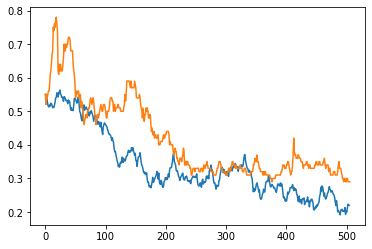

In [13]:
plt.plot(list_paths)
plt.plot(rates[:506])
plt.show()


### OLS Calibration

Instead of Using MLE we can use OLS regression.

When approximizing the SDE by a scheme, we get : 

$\Delta X_t = \theta (\mu - X_t) \Delta t + \sigma \Delta t \epsilon$

where $\epsilon$ follows a normal distribution, then by setting $\Delta t = \frac{1}{252}$ we have : 

$\Delta X_t = \theta \mu - \frac{1}{252}\theta X_t  +  \frac{1}{252} \sigma \epsilon$

Where we recognize a linear regression form. We can just adjust the parameters to then obtain our coefficients

In [14]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [15]:
def OLS_regressor(time_series):
    
    #We will train our data on one year (252 points) and then forecast at year 2
    observed_data = time_series[:252]
    y = np.diff(observed_data)
    X = observed_data[:-1]
    X = sm.add_constant(X)
    model = OLS(y,X)
    results = model.fit()
    k =  - results.params[1] * 252
    theta = results.params[0] / k
    y_hat = model.predict(results.params,X)
    sigma = np.std(y - y_hat)* 252
    
    return [k,theta,sigma]

In [16]:
def SK_regressor(time_series):
    X_t = time_series[:252]
    y = np.diff(X_t)
    X = X_t[:-1].reshape(-1, 1)
    reg = LinearRegression(fit_intercept=True)
    reg.fit(X, y)
    # regression coeficient and constant
    k = -reg.coef_[0]*252
    theta = reg.intercept_ / k
    y_hat = reg.predict(X)
    sigma = np.std(y - y_hat)*252
    return [k,theta,sigma]

In [17]:
k_ols, theta_ols ,sigma_ols = OLS_regressor(rates)
k_sk, theta_sk, sigma_sk = SK_regressor(rates)

In [18]:
OLS_calibration = simulate_vasicek_euler_average(rates[0],k_ols,theta_ols,sigma_ols,2,1/252,1)
SK_calibration =  simulate_vasicek_euler_average(rates[0],k_sk,theta_sk,sigma_sk,2,1/252,1)

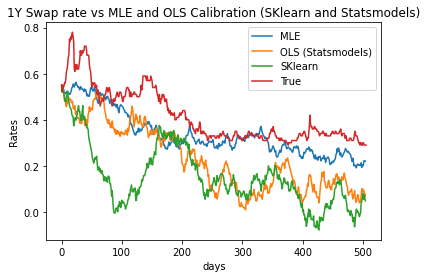

In [19]:
plt.plot(list_paths,label='MLE')
plt.plot(OLS_calibration,label='OLS (Statsmodels)')
plt.plot(SK_calibration,label='SKlearn')
plt.plot(rates[:506],label='True')
plt.title('1Y Swap rate vs MLE and OLS Calibration (SKlearn and Statsmodels)')
plt.xlabel('days')
plt.ylabel('Rates')
plt.legend()
plt.show()
plt.show()

As we can see and expect, it is quite difficult to calibrate using OLS when having only one year worth of data as the one factor Vasicek is not rich enought to capture all the subtilities of the rates. We will now try calibrating it on all of the dataset.

In [56]:
def OLS_regressor_all(time_series):
    
    #We will train our data on one year (252 points) and then forecast at year 2
    observed_data = time_series
    y = np.diff(observed_data)
    X = observed_data[:-1]
    X = sm.add_constant(X)
    model = OLS(y,X)
    results = model.fit()
    theta =  - results.params[1] * 252
    mu = results.params[0] / theta
    y_hat = model.predict(results.params,X)
    sigma = np.std(y - y_hat)* 252
    
    return [theta,mu,sigma]

def SK_regressor_all(time_series):
    X_t = time_series
    y = np.diff(X_t)
    X = X_t[:-1].reshape(-1, 1)
    reg = LinearRegression(fit_intercept=True)
    reg.fit(X, y)
    
    # regression coeficient and constant
    theta = -reg.coef_[0]*252
    mu = reg.intercept_ / theta
    y_hat = reg.predict(X)
    sigma = np.std(y - y_hat)*252
    return [theta,mu,sigma]

In [21]:
def log_likelihood_vasicek_all(estimator,time_series):
    
    dt = 1/252 #trading days per year
    k = estimator[0]
    theta = estimator[1]
    sigma = estimator[2]
    
    x_t1 = time_series[1:]
    x_t0 = time_series[:-1]
    
    mean_t0 = mean(x_t0,dt,k,theta)
    var_t0 = var(dt,k,sigma)
    
    # sum of log-density of normal distributions with mean E[X_t] and Var[X_t]
    log_likelihood = np.sum(np.log(scipy.stats.norm.pdf(x_t1,loc=mean_t0,scale=var_t0)))
    
    return -log_likelihood

rates = swap_rates['DSWP1'].values
constraints = [{'type':'ineq', 'fun': lambda k: k},
               {'type':'ineq', 'fun': lambda sigma: sigma}]

starting_point = [1,5,1]

def optimizer_all(rates):
    opt = minimize(fun=log_likelihood_vasicek_all,x0=starting_point,args=(rates,),constraints=constraints)

        
    k, theta, sigma = opt.x

    
    return opt.x

In [22]:
mle_vasicek = simulate_vasicek_euler_average(rates[0],optimizer_all(rates)[0],optimizer(rates)[1],optimizer(rates)[2],5,1/252,1)
k_sk_all, theta_sk_all, sigma_sk_all = SK_regressor_all(rates)
sk_vasicek = simulate_vasicek_euler_average(rates[0],k_sk_all,theta_sk_all,sigma_sk_all,5,1/252,1)
k_ols_all, theta_ols_all, sigma_ols_all = OLS_regressor_all(rates)
OLS_vasicek = simulate_vasicek_euler_average(rates[0],k_ols_all,theta_ols_all,sigma_ols_all,5,1/252,1)

C:\Users\nalya\AppData\Local\Temp\ipykernel_22936\564908098.py:15: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(scipy.stats.norm.pdf(x_t1,loc=mean_t0,scale=var_t0)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1870: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\nalya\AppData\Local\Temp\ipykernel_22936\3472190341.py:25: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(scipy.stats.norm.pdf(x_t1,loc=mean_t0,scale=var_t0)))
C:\Users\nalya\AppData\Local\Temp\ipykernel_22936\3472190341.py:6: RuntimeWarning: overflow encountered in exp
  return x* np.exp(-k*dt) + theta*(1-np.exp(-k*dt))
C:\Users\nalya\AppData\Local\Temp\ipykernel_22936

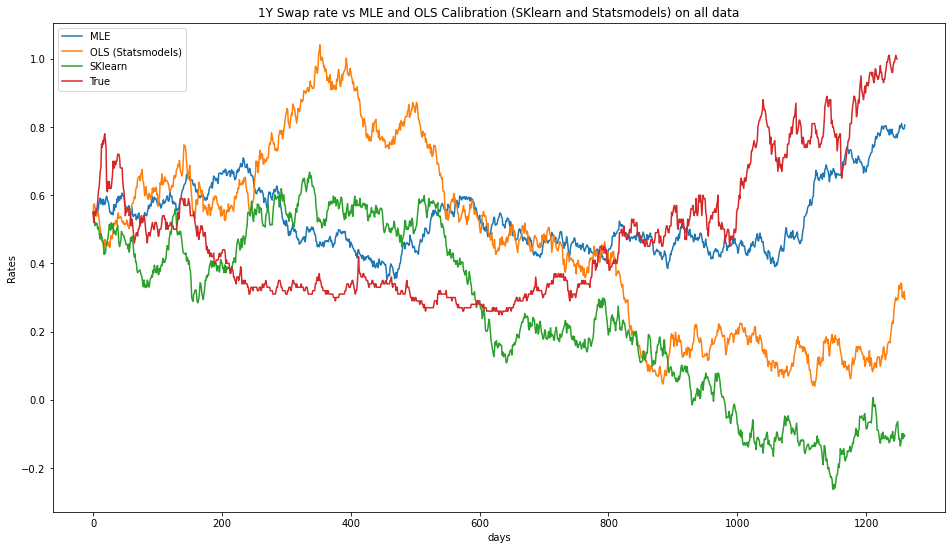

In [23]:
plt.figure(figsize=(16,9))
plt.plot(mle_vasicek,label='MLE')
plt.plot(OLS_vasicek,label='OLS (Statsmodels)')
plt.plot(sk_vasicek,label='SKlearn')
plt.plot(rates,label='True')
plt.title('1Y Swap rate vs MLE and OLS Calibration (SKlearn and Statsmodels) on all data')
plt.xlabel('days')
plt.ylabel('Rates')
plt.legend()
plt.show()
plt.show()

### Bond Pricing

Now that we have calibrated our model, we can now price Zero Coupon Bonds.

Under the Vasicek model, we know that the bond price is : 

$B(t,T,r_t) = exp(-A(t,T)r_t + D(t,T))$ 

Where $A(t,T) = \frac{1-e^{-\theta(T-t)}}{\theta}$

and 

$D(t,T) = (\mu - \frac{\sigma^2}{2\theta^2})[A(t,T) - (T-t)] - \frac{\sigma^2 A(t,T)^2}{4\theta}$

reference : http://www.kurims.kyoto-u.ac.jp/EMIS/journals/HOA/JAMDS/8/11.pdf

Using this formula, we can now compare the two calibration methods

In [39]:
def A(t,T,theta):
    return 1 - np.exp(-theta*(T-t)) / theta

def D(t,T,theta,mu,sigma):
    first_par = (mu - (sigma**2/2*theta))
    middle_par = A(t,T,theta) - (T-t)
    last_par = (sigma**2 * A(t,T,theta)**2) / 4*theta
    
    return first_par*middle_par - last_par

def bond_pricer(t,T,rates,theta,mu,sigma):
    At = A(t,T,theta)
    Dt = D(t,T,theta,mu,sigma) 
    return np.exp(-At*rates + Dt)

In [53]:
MLE_bond = bond_pricer(0,1,rates,optimizer_all(rates)[1],optimizer_all(rates)[0],optimizer_all(rates)[2])
OLS_bond = bond_pricer(0,1,rates,k_ols,theta_ols,sigma_ols)

C:\Users\nalya\AppData\Local\Temp\ipykernel_22936\564908098.py:15: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(scipy.stats.norm.pdf(x_t1,loc=mean_t0,scale=var_t0)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1870: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


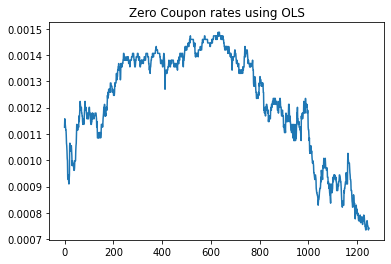

In [55]:
plt.plot(OLS_bond)
plt.title('Zero Coupon rates using OLS')
plt.show()